## Описание проекта

Необходимо построить модель для определения стоимости автомобиля исходя из его параметров. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Подключение библиотек

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as ltb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import warnings                                                  # импорт службы warnings
warnings.simplefilter("ignore")                                  # игнорируем предупреждения
from tqdm import tqdm
tqdm.pandas()

### Чтение данных

In [82]:
data = pd.read_csv('...')         

### Знакомство с датафреймом

In [83]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [84]:
data.head()                 # вывод на экран первые 5 строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Вывод**

Некоторые столбцы с данными содержат пропуски и имеют тип object. Кроме того, данные содержат параметры которые нельзя отнести к признакам, влияющим на итоговую цену:

- DateCreated — дата создания анкеты, 
- DateCrawled — дата скачивания анкеты из базы, 
- NumberOfPictures — количество фотографий автомобиля, 
- PostalCode — почтовый индекс владельца анкеты (пользователя), 
- LastSeen — дата последней активности пользователя, 
- RegistrationMonth — месяц регистрации автомобиля.

Кроме того, формат названия признаков не соответсвует принятому. 

### Переименование столбцов

In [85]:
data.rename(columns={'DateCrawled': 'date_crawled','Price': 'price', 'VehicleType': 'vehicle_type',
                    'RegistrationYear': 'registration_year', 'Gearbox':'gearbox', 'Power': 'power',
                    'Model':'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month',
                    'FuelType':'fuel_type', 'Brand':'brand', 'NotRepaired': 'not_repaired', 'DateCreated':
                     'date_created', 'NumberOfPictures':'number_of_pictures', 'PostalCode': 'postal_code',
                    'LastSeen':'last_seen'}, inplace=True)
data.head()   # проверка переименования        

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Фильтрация некорректных значений

В датафрейме присутствуют данные с некорректными значениями признаков, например, год регистрации автомобиля превышает нынешний, аналогично с мощностью двигателя: кто-то продаёт ТС с 20000 л.с. - слишком мощно для земных колесниц.

**Ошибки в дате регистрации автомобиля**

In [86]:
data = data[data['registration_year'] > 1920]   # делаем срез по годам регистрации, превышающим время начала распространения 
                                                # авто

In [87]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format = '%Y-%m-%d %H:%M:%S')

data = data[data['registration_year'] <= data['date_crawled'].dt.year.max()]  # делаем срез по годам регистрации, 
# не превышающим последний год загрузки данных

<AxesSubplot:>

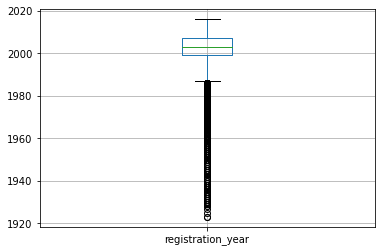

In [88]:
data.boxplot('registration_year') # проверка фильтрации ошибок в году регистрации 

**Вывод**

Медианное значение близко к началу 2000-х, а третий квартиль к 2007...

**Ошибки в мощности двигателя автомобиля**

In [89]:
data = data[data['power'] <= 1700] # делаем срез по мощностям двигателя, не превышающим макс. мощность самого крутого суперкара
data = data[data['power'] > 10]    # делаем срез по мощностям двигателя, превышающим мин. мощность драндулета

<AxesSubplot:>

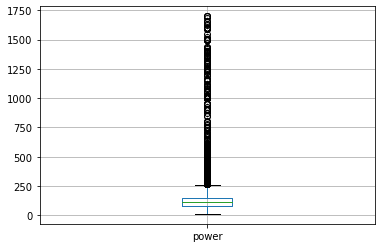

In [90]:
data.boxplot('power') # проверка фильтрации ошибок в мощности двигателя

**Вывод**

Медианное значение мощности близка к 140 л.с., похоже на правду.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

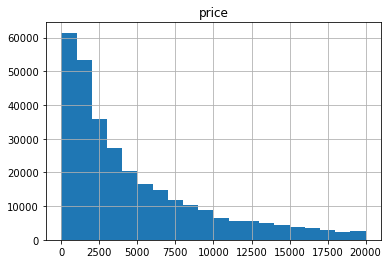

In [91]:
data.hist('price',bins = 20)

Видим, что около максимальное количество предложений находятся около 0, изучим эту область поподробнее.  

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

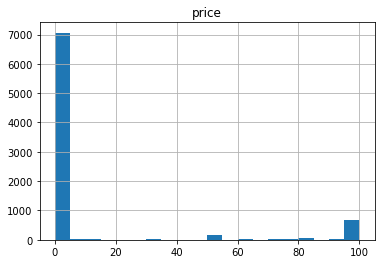

In [92]:
data.hist('price',bins = 20, range = (0,100))

Оказывается, что в выборке присутствуют авто с нулевой стоимостью. Отфильтруем их.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

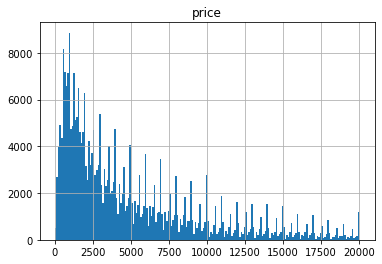

In [93]:
data = data[data['price'] > 5]
data.hist('price',bins = 200, range = (0, 20000))

<div class="alert alert-info"> <b>Комментарий студента:</b> 
    
**Вывод**

Распределение стало похожим на Пуассоновское, что близко к реальной ситуации.

In [94]:
data.info()                       # проверка кол-ва объектов после фильтрации

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295858 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295858 non-null  datetime64[ns]
 1   price               295858 non-null  int64         
 2   vehicle_type        284943 non-null  object        
 3   registration_year   295858 non-null  int64         
 4   gearbox             290525 non-null  object        
 5   power               295858 non-null  int64         
 6   model               284868 non-null  object        
 7   kilometer           295858 non-null  int64         
 8   registration_month  295858 non-null  int64         
 9   fuel_type           280416 non-null  object        
 10  brand               295858 non-null  object        
 11  not_repaired        253136 non-null  object        
 12  date_created        295858 non-null  object        
 13  number_of_pictures  295858 no

### Обработка пропусков

В данных всё ещё много пропусков в признаках, однако все эти пропуски находятся в категориальных признаках. Эти признаки мы должны перевести в числовой тип данных. Последующий способ перевода подразумевает перевод пропусков в отдельную категорию.

### Перевод категориальных признаков в числовой тип данных

In [95]:
lbl = preprocessing.LabelEncoder()              

data['vehicle_type'] = lbl.fit_transform(data['vehicle_type'].astype(str)) #
data['gearbox'] = lbl.fit_transform(data['gearbox'].astype(str))           # перевод категориальных признаков с типом данных
data['model'] = lbl.fit_transform(data['model'].astype(str))               # object в числовой тип данных. Каждому уникальному
data['fuel_type'] = lbl.fit_transform(data['fuel_type'].astype(str))       # значению категориального признака ставится в соот-
data['brand'] = lbl.fit_transform(data['brand'].astype(str))               # ветствие число.
data['not_repaired'] = lbl.fit_transform(data['not_repaired'].astype(str)) #

data.info()                        # проверка изменения типа категориальных данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295858 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        295858 non-null  datetime64[ns]
 1   price               295858 non-null  int64         
 2   vehicle_type        295858 non-null  int32         
 3   registration_year   295858 non-null  int64         
 4   gearbox             295858 non-null  int32         
 5   power               295858 non-null  int64         
 6   model               295858 non-null  int32         
 7   kilometer           295858 non-null  int64         
 8   registration_month  295858 non-null  int64         
 9   fuel_type           295858 non-null  int32         
 10  brand               295858 non-null  int32         
 11  not_repaired        295858 non-null  int32         
 12  date_created        295858 non-null  object        
 13  number_of_pictures  295858 no

**Вывод**

Все категориальные признаки переведены в числовой формат. Признаки принимают значение от 0 до N, где N - число исходных уникальных значений категориальных признаков. Кроме того, такая кодировка позволяет решить проблему с пропусками: она их определяет в отдельную категорию.

## Обучение моделей

### Разделение исходных данных на выборки

In [96]:
data_train_valid, data_test = train_test_split(                  #  разделяем данные на тестовую выборку и оставшуюся                                 
    data, test_size=0.2, random_state=12345)                     #

features_test = data_test.drop(                                                                                        #                                       #
        ['price','date_created','date_crawled','number_of_pictures', 'postal_code','last_seen', 'registration_month'], #
        axis=1)                                                                                                        #
target_test = data_test.price                                                                                          #
#  выделили целевой признак и признаки в тестовой выборке, выделяем только те признаки, что по логике влияют на цену авто   

#######################################################################################################################
features_train, features_valid, target_train, target_valid = train_test_split(                                        # 
    data_train_valid.drop(                                                                                                        #
        ['price','date_created','date_crawled','number_of_pictures', 'postal_code','last_seen', 'registration_month'],# 
        axis=1), data_train_valid.price, test_size=0.25, random_state=12345)                                                      #
#######################################################################################################################
# создаём из оставшейся выборки - обучающую и валидационную, выделяем только те признаки, что по логике влияют на цену 
# авто, выделяем целевой признак

### Масштабирование признаков

In [97]:
scaler = StandardScaler()
scaler.fit(features_train)                        # обучаем стандартизатор, он вычисляет дисперсию и среднее и использует их
                                                  # при масштабировании
features_train = scaler.transform(features_train) # масштабируем признаки обучающей выборки
features_valid = scaler.transform(features_valid) # масштабируем признаки валидационной выборки

### Модель LGBM

In [98]:
model_LGBM = ltb.LGBMRegressor(random_state='12345')            # выбор модели с гиперпараметром random_state

model_LGBM.fit(features_train, target_train)                    # обучение модели

pred_valid = model_LGBM.predict(features_valid)                 # построение предсказаний
RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5    # вычисление RMSE
print('Корень среднего квадратического отклонения:', RMSE)

Корень среднего квадратического отклонения: 1699.5553584450204


### LGBM c изменённой глубиной дерева

По умолчанию в модели нет ограничений на глубину дерева, попробуем это исправить и посмотреть, как это скажется на точности.

In [99]:
RMSE_best = 10000
for depth in range(1,16):
    model_LGBM_depth = ltb.LGBMRegressor(max_depth = depth, random_state='12345')

    model_LGBM_depth.fit(features_train, target_train)

    pred_valid = model_LGBM_depth.predict(features_valid)
    RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
    if RMSE < RMSE_best:
        model_LGBM_depth_best = model_LGBM_depth
        best_depth = depth
        RMSE_best = RMSE
print(f'Корень среднего квадратического отклонения для глубины дерева {best_depth}:', RMSE_best)

Корень среднего квадратического отклонения для глубины дерева 13: 1699.031527057152


**Вывод**

Метрика качества улучшилась при ограничении глубины дерева, видимо модель по умолчанию сильно разрастается в глубину.

### LGBM c изменённой глубиной дерева и количеством листьев


In [100]:
RMSE_best = 10000
for leaves in range(1000,1010):
    model_LGBM_depth_leaves = ltb.LGBMRegressor(max_depth=13, num_leaves = leaves, random_state='12345')

    model_LGBM_depth_leaves.fit(features_train, target_train)

    pred_valid = model_LGBM_depth_leaves.predict(features_valid)
    RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
    if RMSE < RMSE_best:
        model_LGBM_depth_leaves_best = model_LGBM_depth_leaves
        best_leaves = leaves
        RMSE_best = RMSE
print(f'Корень среднего квадратического отклонения с макс. количеством листьев {best_leaves}:', RMSE_best)

Корень среднего квадратического отклонения с макс. количеством листьев 1009: 1552.005298968338


### LGBM c изменённой глубиной дерева, количеством  листьев и скоростью обучения

In [101]:
RMSE_best = 10000
for rate in np.arange(0.05,1,0.05):
    model_LGBM_depth_rate = ltb.LGBMRegressor(max_depth=13, num_leaves = 1009, learning_rate = rate, random_state='12345')

    model_LGBM_depth_rate.fit(features_train, target_train)

    pred_valid = model_LGBM_depth_rate.predict(features_valid)
    RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
    if RMSE < RMSE_best:
        model_LGBM_depth_rate_best = model_LGBM_depth_rate
        best_rate = rate
        RMSE_best = RMSE
print(f'Корень среднего квадратического отклонения со скоростью обучения {best_rate}:', RMSE_best)


Корень среднего квадратического отклонения со скоростью обучения 0.15000000000000002: 1551.5652026349126


### Заполнение простым средним

In [102]:
mean = target_train.mean()
pred_valid = np.ones(len(target_valid)) * mean
RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
print('Корень среднего квадратического отклонения:', RMSE)

Корень среднего квадратического отклонения: 4604.371279787227


### Модель случайного леса

In [103]:
model_forest = RandomForestRegressor(random_state=12345)
model_forest.fit(features_train, target_train)
pred_valid = model_forest.predict(features_valid)
RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
print('Корень среднего квадратического отклонения:', RMSE)

Корень среднего квадратического отклонения: 1605.5662822787483


### Модель линейной регрессии

In [104]:
model_regression = LinearRegression()
model_regression.fit(features_train, target_train)
pred_valid = model_regression.predict(features_valid) 
RMSE = (mean_squared_error(target_valid, pred_valid)) ** 0.5
print('Корень среднего квадратического отклонения:', RMSE)

Корень среднего квадратического отклонения: 3158.7199930863912


## Анализ моделей

### Модель LGBM

In [105]:
%%time                                       
# вычисление времени исполнения кода

model_LGBM.fit(features_train, target_train)

Wall time: 992 ms


LGBMRegressor(random_state='12345')

In [106]:
%%time

pred_valid = model_LGBM.predict(features_valid)

Wall time: 168 ms


### Модель LGBM с изменённой глубиной дерева

In [107]:
%%time

model_LGBM_depth_best.fit(features_train, target_train)

Wall time: 916 ms


LGBMRegressor(max_depth=13, random_state='12345')

In [108]:
%%time

pred_valid = model_LGBM_depth_best.predict(features_valid)

Wall time: 164 ms


### LGBM c изменённой глубиной дерева и количеством листьев

In [109]:
%%time

model_LGBM_depth_leaves_best.fit(features_train, target_train)

Wall time: 3.88 s


LGBMRegressor(max_depth=13, num_leaves=1009, random_state='12345')

In [110]:
%%time

pred_valid = model_LGBM_depth_leaves_best.predict(features_valid)

Wall time: 528 ms


### LGBM c изменённой глубиной дерева, количеством  листьев и скоростью обучения

In [111]:
%%time

model_LGBM_depth_rate_best.fit(features_train, target_train)

Wall time: 3.22 s


LGBMRegressor(learning_rate=0.15000000000000002, max_depth=13, num_leaves=1009,
              random_state='12345')

In [112]:
%%time

pred_valid = model_LGBM_depth_rate_best.predict(features_valid)

Wall time: 490 ms


### Модель случайного леса

In [113]:
%%time

model_forest.fit(features_train, target_train)

Wall time: 1min 25s


RandomForestRegressor(random_state=12345)

In [114]:
%%time

pred_valid = model_forest.predict(features_valid)

Wall time: 3.13 s


### Модель линейной регрессии

In [115]:
%%time

model_regression.fit(features_train, target_train)

Wall time: 80.3 ms


LinearRegression()

In [116]:
%%time

pred_valid = model_regression.predict(features_valid)

Wall time: 2 ms


**Вывод**

Модели LGBM показывают хорошие метрики качества, на уровне модели случайного леса, однако процесс обучения и предсказания происходит гораздо быстрее. Путём варьирования гиперпараметров можно добиться уточнения модели LGBM. Качество модели будет даже превышать качество случайного леса, а скорость обучения при этом упадёт, но всё равно будет заметно выше. 

Самой лучшей метрикой обладает модель LGBM с оптимальным ограничением глубины деревьев, количества листьев и оптимальной скоростю обучения.

Самым быстрым методом является линейная регрессия, но качество предсказаний оставляет желать лучшего.

### Тест лучшей модели

In [117]:
features_train_valid = data_train_valid.drop(                                                                         #                              #
        ['price','date_created','date_crawled','number_of_pictures', 'postal_code','last_seen', 'registration_month'],# 
        axis=1)                                                                                                       #
target_train_valid = data_train_valid.price                                                                           # 
############## Используем для обучения лучшей модели и обучающую и валидационную выборки ##############################

model_LGBM_depth_rate_best.fit(features_train_valid, target_train_valid)

pred_test = model_LGBM_depth_rate_best.predict(features_test)

RMSE = (mean_squared_error(target_test, pred_test)) ** 0.5
print('Корень среднего квадратического отклонения лучшей модели на тестовой выборке:', RMSE)

Корень среднего квадратического отклонения лучшей модели на тестовой выборке: 1527.5180636338787


## Общий вывод

В данной работе нам пришлось работать с датафреймом, требующим предварительной обработки перед тем, кам обучать на нём модели. В первую очередь, были определены признаки, которые не должны влиять на стоимость авто. Затем признаки, влияющие на стоимость авто (мощность двигателя, год регистрации) были отфильрованы от некорректных значений.

На следующем этапе категориальные признаки были переведены в числовой тип данных. Методом LabelEncoder() была решена и проблема пропусков: они были записаны в отдельную категорию. 

Дальнейшим этапом стало масштабирование признаков. Поскольку некоторые методы оказываются чувствительны к масшабированию, а некоторые нет, то при сравнении различных методов лучше перестраховаться и его выполнить.

Далее была рассмотрена модель LGBM: были построены 4 модели
- по-умолчанию
- с оптимальным ограничением глубины деревьев
- с оптимальным ограничением глубины деревьев и количества листьев
- с оптимальным ограничением глубины деревьев, количества листьев и оптимальной скоростю обучения

Для сравнения рассмотрены модели случайного леса, регрессии и заполнение средним. Метрикой качества выступала RMSE. Кроме того, важным параметром являлась скорость обучения и предсказания результата. 

 **RMSE**
 
- LGBM по-умолчанию:      1700
- LGBM с оптимальным ограничением глубины деревьев: 1699
- LGBM с оптимальным ограничением глубины деревьев и количества листьев: 1552
- LGBM с оптимальным ограничением глубины деревьев, количества листьев и оптимальной скоростю обучения:  1552
- случайный лес: 1606
- линейная регрессия: 3159
- заполнение средним: 4604

Как видно из результатов модель LGBM по качеству близка к модели случайного леса. Что касается гиперпараметров модели, то существенной влияние оказало ограничение максимального количества листьев, в то время как ограничение максимальной глубины не повлияло на точность. Оптимальной скоростью обучения оказалась, скорость 0.15

**Скорость обучения и предсказания**

- LGBM по-умолчанию:       1 s + 167 ms
- LGBM с оптимальным ограничением глубины деревьев: 936 ms + 158 ms
- LGBM с оптимальным ограничением глубины деревьев и количества листьев:  3.93 s +  525 ms
- LGBM с оптимальным ограничением глубины деревьев, количества листьев и оптимальной скоростю обучения: 3.38 s + 491 ms
- случайный лес: 1min 31s + 3.21 s
- линейная регрессия: 83.3 ms + 3 ms

Самой быстрой является линейная регрессия, но и результат соответсвтующий. LGBM по скорости обучения и предсказания обходит модель случайного леса более чем в 25 раз! Вспоминая, что RMSE у них близкие, можно сделать вывод: если результат примерно одинаковый, зачем ждать его дольше. Кроме того, изменение скорости обучения в модели LGBM с 0.1 до 0.15 вылилось в уменьшении времени обучения и построения предсказаний.

Финальная проверка лучшей модели LGBM с оптимальным ограничением глубины деревьев, количества листьев и оптимальной скоростю обучения на тестовой выборке показала RMSE: 1528  

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей